# Imagewoof CNN Classifier - PyTorch (CPU vs. GPU) 

Note: this notebook is nearly the same as the `cnn.ipynb` (CNN is one layer deeper here) notebook but it trains the network on both a GPU and a CPU to visualize the difference in training time. 

In this notebook, I'll be training a convolutional neural network in PyTorch on a GPU on the imagewoof dataset (from [here](https://github.com/fastai/imagenette)) containing ~10000 samples of 10 classes of different dog breeds. 

## 1. Data import and visualization

In [1]:
import numpy as np
import gzip

data_path = "../../data/imagewoof.npy.gz"
f = gzip.GzipFile(data_path, "r")
data_set = np.load(f, allow_pickle=True)

In [209]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from util import *

In [210]:
from torch.utils.data import Dataset, TensorDataset

class GetDataset(Dataset):
    def __init__(self, data_set): # samples and labels are stored in tuples in data_set (list)
        self.data_distribution = data_set
    
    def __getitem__(self, index):
        sample = self.data_distribution[index][0]
        label = self.data_distribution[index][1]
        return (torch.tensor(sample, dtype=torch.float), torch.tensor(label, dtype=torch.int64)) 
    
    def __len__(self):
        return len(self.data_distribution)

In [211]:
torch_set = GetDataset(data_set)

In [212]:
torch_set.__len__()

9025

In [213]:
TRAIN_RATIO = 0.90  # 80/20 split (customize to your liking) 
train_size = int(TRAIN_RATIO * len(torch_set))
test_size = len(torch_set) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(torch_set, [train_size, test_size])

In [214]:
train_dataset.__len__()

8122

In [215]:
test_dataset.__len__()

903

In [216]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32) 
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [217]:
for sample in trainloader:
    print(sample[0].shape)
    print(sample[1])
    break

torch.Size([32, 3, 160, 160])
tensor([9, 6, 6, 6, 4, 0, 1, 7, 3, 9, 2, 7, 4, 8, 1, 2, 4, 5, 6, 9, 4, 0, 6, 8,
        8, 7, 5, 2, 2, 0, 4, 1])


Data formatting: each sample is a batch of 32. `sample` is a list containing two tensors: one holding the image samples and the other holding the labels. In a batch of 32. i.e. all of the x's are in a tensor of length 32 and all of the y's are in a list of same length. Let us do some plotting: 

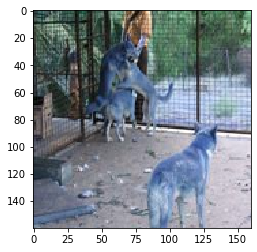

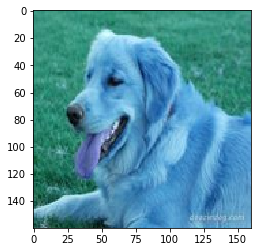

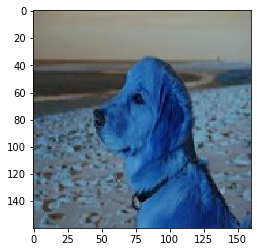

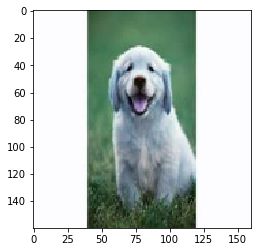

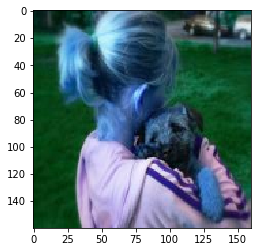

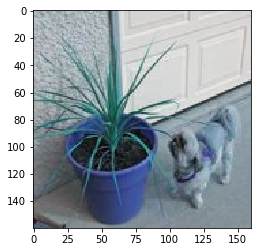

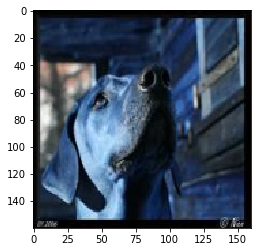

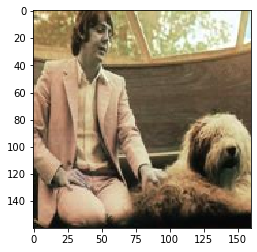

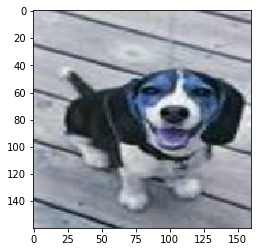

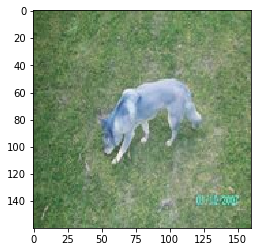

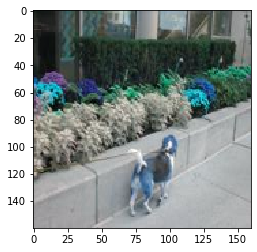

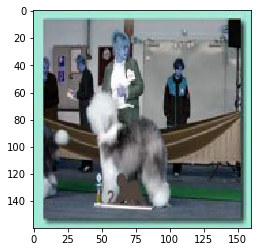

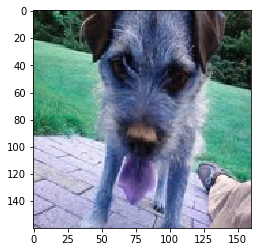

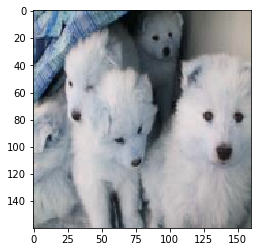

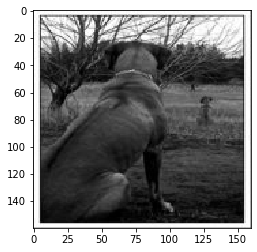

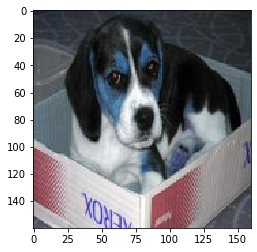

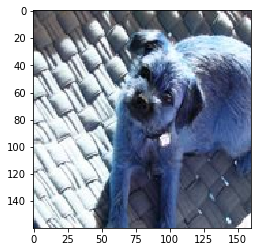

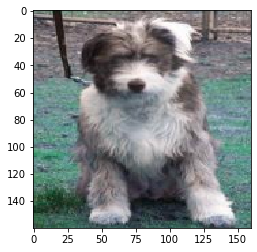

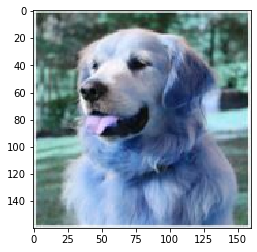

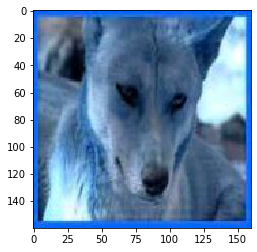

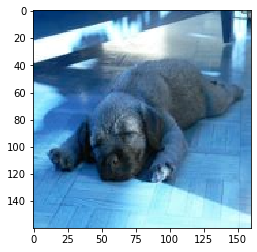

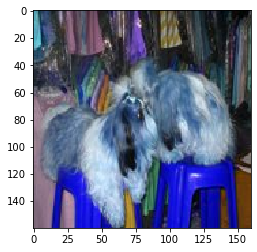

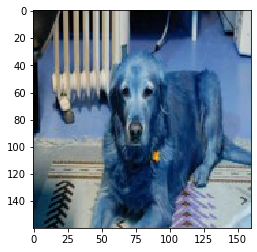

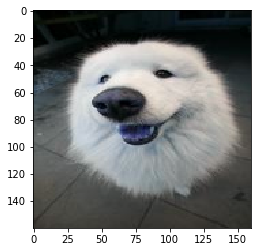

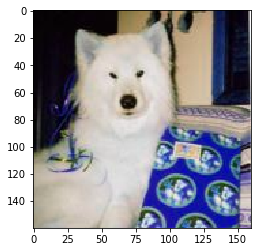

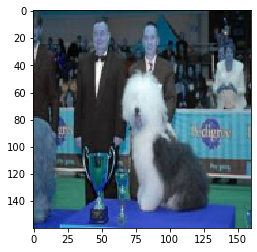

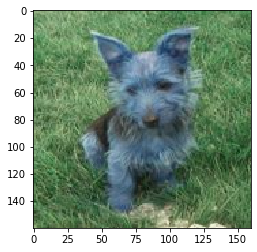

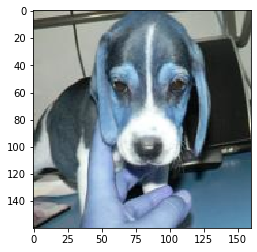

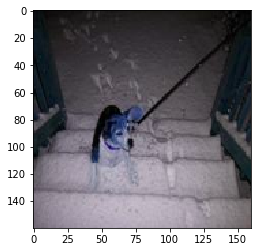

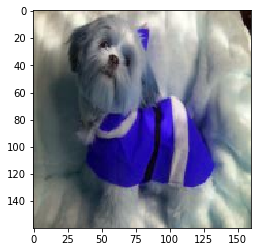

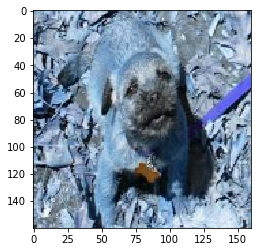

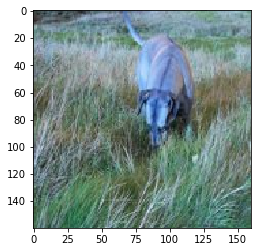

In [218]:
for batch in trainloader:
    images = sample[0]
    labels = sample[1]
    for image in images:
        plot_image = torch.movedim(image, 0, 2)
        plot_tensor(plot_image, True)
    break

## 2. Build the model 

In [295]:
import torch.nn as nn
import torch.nn.functional as F

In [296]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # pool 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fc
        self.fc1 = nn.Linear(16 * 40 * 40, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        # conv 
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
                
        # fc 
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [297]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [298]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params

3309418

In [299]:
param_size = 0
for param in net.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in net.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('network size: {:.3f}MB'.format(size_all_mb))

network size: 12.624MB


In [300]:
for batch in trainloader:
    out = net(batch[0])
    print(out.shape)
    print(batch[1].shape)
    break

torch.Size([32, 10])
torch.Size([32])


**GPU**: 

In [301]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [302]:
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## 3. Train 

In [303]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
MOMENTUM_VALUE = 0.9
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_VALUE)

In [ ]:
%%time
from tqdm import tqdm
import time

enum = 0
elosses = []
NUM_EPOCHS = 250
start_time = time.time()
epoch_time = time.time()

for epoch in range(NUM_EPOCHS):
    enum += 1
    running_loss = 0.0
    
    for data in trainloader:
        # 1. get data 
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        # 2. zero out grads 
        optimizer.zero_grad()
        
        # 3. forward + backward + optimize
        logits = net(inputs)
        loss_val = criterion(logits, labels)
        loss_val.backward()
        optimizer.step()
        
        running_loss += loss_val
    
    # loss stats 
    epoch_loss = (running_loss/len(trainloader)).cpu().detach().numpy()
    elosses.append(epoch_loss)
    print('Loss epoch {}: '.format(enum), epoch_loss)
    
    # timing 
    new_time = time.time()
    print("Total time (s): ", int(new_time - start_time))
    print("Epoch time (s): ", int(new_time - epoch_time))
    print("-------------------------")
    epoch_time = time.time()

Loss epoch 1:  2.3023596
Total time (s):  6
Epoch time (s):  6
-------------------------
Loss epoch 2:  2.2959216
Total time (s):  12
Epoch time (s):  6
-------------------------
Loss epoch 3:  2.2872498
Total time (s):  18
Epoch time (s):  6
-------------------------
Loss epoch 4:  2.2540505
Total time (s):  24
Epoch time (s):  6
-------------------------
Loss epoch 5:  2.1905584
Total time (s):  30
Epoch time (s):  6
-------------------------
Loss epoch 6:  2.1151187
Total time (s):  36
Epoch time (s):  6
-------------------------
Loss epoch 7:  2.0652173
Total time (s):  42
Epoch time (s):  6
-------------------------
Loss epoch 8:  2.0307913
Total time (s):  48
Epoch time (s):  6
-------------------------
Loss epoch 9:  1.9964687
Total time (s):  55
Epoch time (s):  6
-------------------------
Loss epoch 10:  1.9653181
Total time (s):  61
Epoch time (s):  6
-------------------------
Loss epoch 11:  1.9423292
Total time (s):  67
Epoch time (s):  6
-------------------------
Loss epoc

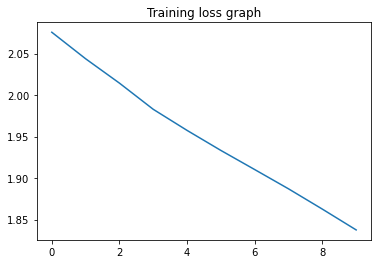

In [287]:
import matplotlib.pyplot as plt
plt.plot(elosses)
plt.title("Training loss graph")
plt.show()

### Aside: see GPU speedup 

We will now run the same training loop but with the model allocated on the CPU instead of the GPU and see what type of slow down we get. 

In [288]:
cpu_net = Net()

In [289]:
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
MOMENTUM_VALUE = 0.9
optimizer = optim.SGD(cpu_net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_VALUE)

In [290]:
%%time
from tqdm import tqdm
import time

enum = 0
elosses = []
NUM_EPOCHS = 10
start_time = time.time()
epoch_time = time.time()

for epoch in range(NUM_EPOCHS):
    enum += 1
    running_loss = 0.0
    
    for data in trainloader:
        # 1. get data 
        inputs = data[0]
        labels = data[1]
        
        # 2. zero out grads 
        optimizer.zero_grad()
        
        # 3. forward + backward + optimize
        logits = cpu_net(inputs)
        loss_val = criterion(logits, labels)
        loss_val.backward()
        optimizer.step()
        
        running_loss += loss_val
    
    # loss stats 
    epoch_loss = (running_loss/len(trainloader)).cpu().detach().numpy()
    elosses.append(epoch_loss)
    print('Loss epoch {}: '.format(enum), epoch_loss)
    
    # timing 
    new_time = time.time()
    print("Total time (s): ", int(new_time - start_time))
    print("Epoch time (s): ", int(new_time - epoch_time))
    print("-------------------------")
    epoch_time = time.time()

Loss epoch 1:  2.3006911
Total time (s):  25
Epoch time (s):  25
-------------------------
Loss epoch 2:  2.296844
Total time (s):  51
Epoch time (s):  26
-------------------------
Loss epoch 3:  2.2940927
Total time (s):  73
Epoch time (s):  21
-------------------------
Loss epoch 4:  2.290384
Total time (s):  99
Epoch time (s):  26
-------------------------
Loss epoch 5:  2.2775433
Total time (s):  125
Epoch time (s):  25
-------------------------
Loss epoch 6:  2.2341855
Total time (s):  151
Epoch time (s):  26
-------------------------
Loss epoch 7:  2.2025511
Total time (s):  177
Epoch time (s):  25
-------------------------
Loss epoch 8:  2.1631284
Total time (s):  204
Epoch time (s):  26
-------------------------
Loss epoch 9:  2.1060586
Total time (s):  229
Epoch time (s):  25
-------------------------
Loss epoch 10:  2.0735114
Total time (s):  255
Epoch time (s):  25
-------------------------
CPU times: user 29min 55s, sys: 4min 10s, total: 34min 6s
Wall time: 4min 15s


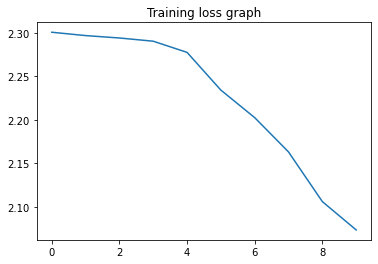

In [292]:
import matplotlib.pyplot as plt
plt.plot(elosses)
plt.title("Training loss graph")
plt.show()

Wow! Quite the speedup (4 min 15s on CPU compared to 1 min 1s)! We will test using the GPU model. 

## 5. Test 

In [294]:
accuracy_count = 0
idx_count = 0

with torch.no_grad():
    for data in testloader:
        # setup 
        images = data[0]  # plotting 
        images = torch.squeeze(images)
        images = torch.movedim(images, 0, 2)
        inputs = data[0].to(device)
        labels = data[1].to(device)
        label = labels.item()
        logits = net(inputs)
        normalized_logits = F.softmax(logits, dim=1)
        preds = torch.argmax(normalized_logits)
        pred = preds.item()

        # calculate 
        if (label == pred):
            accuracy_count += 1
        idx_count += 1

        # display 
        #plot_tensor(images, True)
        #print("Ground truth: ", label)
        #print("Predicted label: ", pred)
        #print("------------------------")
        
#         if idx_count > 10: 
#            break
    
total_accuracy = accuracy_count/idx_count
print("Accuracy on test set: ", total_accuracy * 100)

Accuracy on test set:  33.222591362126245
